In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD
import pickle
import os
from six.moves import cPickle as pickle
import cv2
from keras.preprocessing.image import ImageDataGenerator

In [42]:
Path = 'drive/Shared drives/Data_Mining_Final_Project/'

In [43]:
openDirs = [Path+'Eye_dataset/train_dataset/openLeftEyes/', Path+'Eye_dataset/train_dataset/openRightEyes/']
closeDirs = [Path+'Eye_dataset/train_dataset/closedLeftEyes/', Path+'Eye_dataset/train_dataset/closedRightEyes/']


def generate_dataset(type, dirData):
    dataset = np.ndarray([2474, 24, 24, 1], dtype='float32')
    i = 0
 
    for dir in dirData:
        for filename in os.listdir(dir):
            if filename.endswith('.jpg'):
                im = cv2.imread(dir + '/' + filename)
                # Convert to grayscale image
                im = np.dot(np.array(im, dtype='float32'), [[0.2989], [0.5870], [0.1140]]) / 255
                dataset[i, :, :, :] = im[:, :, :]
                i += 1

    if type == 1:
        labels = np.ones([len(dataset), 1], dtype=int)
    else:
        labels = np.zeros([len(dataset), 1], dtype=int)
    return dataset, labels

def save_train_and_test_set(dataset, labels, train_ratio, val_ratio, pickle_file):
    #split = int(len(dataset) * ratio)
    #train_dataset = dataset[:split]
    #train_labels = labels[:split]
    #test_dataset = dataset[split:]
    #test_labels = labels[split:]

    split1 = int(len(dataset) * train_ratio)
    split2 = int(len(dataset) * (train_ratio + val_ratio))

    train_dataset = dataset[:split1]
    train_labels = labels[:split1]

    test_dataset = dataset[split1:split2]
    test_labels = labels[split1:split2]

    val_dataset = dataset[split2:]
    val_labels = labels[split2:]

    try:
        f = open(pickle_file, 'wb')
        save = {
            'train_dataset': train_dataset,
            'train_labels': train_labels,
            'val_dataset': val_dataset,
            'val_labels': val_labels,
            'test_dataset': test_dataset,
            'test_labels': test_labels,
        }
        pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
        f.close()
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

    statinfo = os.stat(pickle_file)

# Main
if __name__ == '__main__':
    dataset_open, labels_open = generate_dataset(1, openDirs)
    dataset_closed, labels_closed = generate_dataset(0, closeDirs)

    #ratio = 0.8
    train_ratio = 0.8
    val_ratio = 0.1

    pickle_file_open = 'open_eyes.pickle'
    pickle_file_closed = 'closed_eyes.pickle'

    # Save open dataset to pickle file
    save_train_and_test_set(dataset_open, labels_open, train_ratio, val_ratio, pickle_file_open)
    # Save close dataset to pickle file
    save_train_and_test_set(dataset_closed, labels_closed, train_ratio, val_ratio, pickle_file_closed)
    
    
    pickle_files = ['open_eyes.pickle', 'closed_eyes.pickle']
    i = 0
    for pickle_file in pickle_files:
        with open(pickle_file, 'rb') as f:
            save = pickle.load(f)
            if i == 0:
                train_dataset = save['train_dataset']
                train_labels = save['train_labels']
                val_dataset = save['val_dataset']
                val_labels = save['val_labels']
                test_dataset = save['test_dataset']
                test_labels = save['test_labels']
            else:
                train_dataset = np.concatenate((train_dataset, save['train_dataset']))
                train_labels = np.concatenate((train_labels, save['train_labels']))
                val_dataset = np.concatenate((val_dataset, save['val_dataset']))
                val_labels = np.concatenate((val_labels, save['val_labels']))
                test_dataset = np.concatenate((test_dataset, save['test_dataset']))
                test_labels = np.concatenate((test_labels, save['test_labels']))
            del save  # hint to help gc free up memory
        i += 1

    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', val_dataset.shape, val_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

    batch_size = 30
    nb_classes = 1
    nb_epoch = 20

    X_train = train_dataset
    # X_train = X_train.reshape((X_train.shape[0], X_train.shape[3]) + X_train.shape[1:3])
    Y_train = train_labels

    X_val = val_dataset
    Y_val = val_labels

    X_test = test_dataset
    # X_test = X_test.reshape((X_test.shape[0], X_test.shape[3]) + X_test.shape[1:3])
    Y_test = test_labels

    # print data shape
    print("{1} train samples, {4} channel{0}, {2}x{3}".format("" if X_train.shape[1] == 1 else "s", *X_train.shape))
    print("{1}  test samples, {4} channel{0}, {2}x{3}".format("" if X_val.shape[1] == 1 else "s", *X_val.shape))
    print("{1}  test samples, {4} channel{0}, {2}x{3}".format("" if X_test.shape[1] == 1 else "s", *X_test.shape))
    # input image dimensions
    _, img_channels, img_rows, img_cols = X_train.shape

    model = Sequential()
    # first	and	second Conv Layers with pooling
    model.add(Conv2D(32, (3, 3), padding='same',input_shape=(img_channels, img_rows, img_cols)))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # FC layer
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Output layer. Define the class
    model.add(Dense(nb_classes))
    model.add(Activation('sigmoid'))

    # let's train the model using SGD + momentum (how original).
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

    #model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=2, validation_data=(X_test, Y_test))

    # data generator   

    data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

    history= model.fit(data_generator.flow(X_train, Y_train,batch_size), steps_per_epoch=len(X_train) / batch_size, epochs=nb_epoch, verbose=2, validation_data=(X_val, Y_val))

    

    score = model.evaluate(X_val, Y_val, verbose=0)

    print('Loss score:', score[0])
    print('Test accuracy:', score[1] * 100, '%')

    # Save model to file
    model.save(Path+"new_models/model.h5",overwrite=True,include_optimizer=True)
    # print("Save model to file json...")
    # model_json = model.to_json()
    # with open('models/model1.json', "w") as json_file:
    #     json_file.write(model_json)

    # print("Save weights to file...")
    # model.save_weights('models/model1.h5',overwrite=True)

Training set (3958, 24, 24, 1) (3958, 1)
Validation set (496, 24, 24, 1) (496, 1)
Test set (494, 24, 24, 1) (494, 1)
3958 train samples, 1 channels, 24x24
496  test samples, 1 channels, 24x24
494  test samples, 1 channels, 24x24
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


131/131 - 30s - loss: 0.6916 - accuracy: 0.5197 - val_loss: 0.6954 - val_accuracy: 0.5343 - 30s/epoch - 225ms/step
Epoch 2/20
131/131 - 19s - loss: 0.6559 - accuracy: 0.6228 - val_loss: 0.6610 - val_accuracy: 0.5907 - 19s/epoch - 144ms/step
Epoch 3/20
131/131 - 17s - loss: 0.6246 - accuracy: 0.6561 - val_loss: 0.6741 - val_accuracy: 0.5867 - 17s/epoch - 128ms/step
Epoch 4/20
131/131 - 16s - loss: 0.6126 - accuracy: 0.6662 - val_loss: 0.6572 - val_accuracy: 0.6048 - 16s/epoch - 121ms/step
Epoch 5/20
131/131 - 16s - loss: 0.6046 - accuracy: 0.6703 - val_loss: 0.6393 - val_accuracy: 0.6129 - 16s/epoch - 124ms/step
Epoch 6/20
131/131 - 16s - loss: 0.5749 - accuracy: 0.6950 - val_loss: 0.6232 - val_accuracy: 0.6169 - 16s/epoch - 124ms/step
Epoch 7/20
131/131 - 16s - loss: 0.5230 - accuracy: 0.7388 - val_loss: 0.5087 - val_accuracy: 0.6714 - 16s/epoch - 123ms/step
Epoch 8/20
131/131 - 16s - loss: 0.4526 - accuracy: 0.7938 - val_loss: 0.3794 - val_accuracy: 0.8851 - 16s/epoch - 124ms/step
Epo

In [44]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

#history= model.fit(data_generator.flow(X_train, Y_train,batch_size), steps_per_epoch=len(X_train) / batch_size, epochs=nb_epoch, verbose=2, validation_data=(X_test, Y_test))
# print the training accuracy
print('Training loss:', history.history['loss'][-1])
print('Training accuracy:', history.history['accuracy'][-1])

# print the validation accuracy and loss
print('Validation loss:', history.history['val_loss'][-1])
print('Validation accuracy:', history.history['val_accuracy'][-1])


# evaluate the model on the test data
scores = model.evaluate(X_test, Y_test, verbose=0)

# calculate the metrics
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
accuracy = accuracy_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('F1 score:', f1)
print('Precision:', precision)
print('Recall:', recall)

Training loss: 0.13496176898479462
Training accuracy: 0.9499747157096863
Validation loss: 0.09250229597091675
Validation accuracy: 0.9677419066429138
16/16 [==============================] - 1s 41ms/step
Test loss: 0.10311812162399292
Test accuracy: 0.9655870199203491
F1 score: 0.96579476861167
Precision: 0.96
Recall: 0.97165991902834


In [45]:
    model2 = Sequential()
    # first	and	second Conv Layers with pooling
    model2.add(Conv2D(32, (3, 3), padding='same',input_shape=(img_channels, img_rows, img_cols)))
    model2.add(Activation('relu'))
    model2.add(Conv2D(32, (3, 3)))
    model2.add(Activation('relu'))
    model2.add(MaxPooling2D(pool_size=(2, 2)))
    model2.add(Dropout(0.25))

    model2.add(Conv2D(64, (3, 3), padding='same'))
    model2.add(Activation('relu'))
    model2.add(Conv2D(64, (3, 3)))
    model2.add(Activation('relu'))
    model2.add(MaxPooling2D(pool_size=(2, 2)))
    model2.add(Dropout(0.25))

    model2.add(Conv2D(128, (3, 3), padding='same'))
    model2.add(Activation('relu'))
    model2.add(Conv2D(128, (3, 3)))
    model2.add(Activation('relu'))
    model2.add(MaxPooling2D(pool_size=(2, 2)))
    model2.add(Dropout(0.25))

    # FC layer
    model2.add(Flatten())
    model2.add(Dense(512))
    model2.add(Activation('relu'))
    model2.add(Dropout(0.5))

    # Output layer. Define the class
    model2.add(Dense(nb_classes))
    model2.add(Activation('sigmoid'))

    # let's train the model using SGD + momentum (how original).
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model2.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
history2 = model2.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, validation_data=(X_val, Y_val))
score = model2.evaluate(X_val, Y_val, verbose=0)

print('Loss score:', score[0])
print('Test accuracy:', score[1] * 100, '%')

# Save model to file
# model.save(Path+"new_models/model.h5",overwrite=True,include_optimizer=True)
# print("Save model to file json...")
# model_json = model.to_json()
# with open('models/model1.json', "w") as json_file:
#     json_file.write(model_json)

# print("Save weights to file...")
# model.save_weights('models/model1.h5',overwrite=True)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


132/132 [==============================] - 18s 128ms/step - loss: 0.6886 - accuracy: 0.5379 - val_loss: 0.7013 - val_accuracy: 0.4274
Epoch 2/20
132/132 [==============================] - 17s 126ms/step - loss: 0.6359 - accuracy: 0.6316 - val_loss: 0.6929 - val_accuracy: 0.5625
Epoch 3/20
132/132 [==============================] - 16s 125ms/step - loss: 0.6167 - accuracy: 0.6602 - val_loss: 0.6659 - val_accuracy: 0.5887
Epoch 4/20
132/132 [==============================] - 16s 124ms/step - loss: 0.5897 - accuracy: 0.6885 - val_loss: 0.6484 - val_accuracy: 0.6089
Epoch 5/20
132/132 [==============================] - 17s 126ms/step - loss: 0.5148 - accuracy: 0.7494 - val_loss: 0.5137 - val_accuracy: 0.6835
Epoch 6/20
132/132 [==============================] - 17s 125ms/step - loss: 0.4040 - accuracy: 0.8201 - val_loss: 0.4287 - val_accuracy: 0.6855
Epoch 7/20
132/132 [==============================] - 17s 128ms/step - loss: 0.3268 - accuracy: 0.8633 - val_loss: 0.3306 - val_accuracy: 0.9

In [46]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

#history= model.fit(data_generator.flow(X_train, Y_train,batch_size), steps_per_epoch=len(X_train) / batch_size, epochs=nb_epoch, verbose=2, validation_data=(X_test, Y_test))
# print the training accuracy
print('Training loss:', history2.history['loss'][-1])
print('Training accuracy:', history2.history['accuracy'][-1])

# print the validation accuracy and loss
print('Validation loss:', history2.history['val_loss'][-1])
print('Validation accuracy:', history2.history['val_accuracy'][-1])


# evaluate the model on the test data
scores = model2.evaluate(X_test, Y_test, verbose=0)

# calculate the metrics
y_pred = model2.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
accuracy = accuracy_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('F1 score:', f1)
print('Precision:', precision)
print('Recall:', recall)

Training loss: 0.09173513948917389
Training accuracy: 0.9663971662521362
Validation loss: 0.11085829138755798
Validation accuracy: 0.9596773982048035
16/16 [==============================] - 1s 38ms/step
Test loss: 0.11685877293348312
Test accuracy: 0.9635627269744873
F1 score: 0.9638554216867471
Precision: 0.9561752988047809
Recall: 0.97165991902834


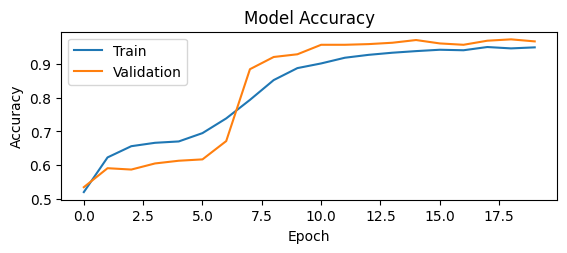

In [47]:
import matplotlib.pyplot as plt

# plot training, validation, and test accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')



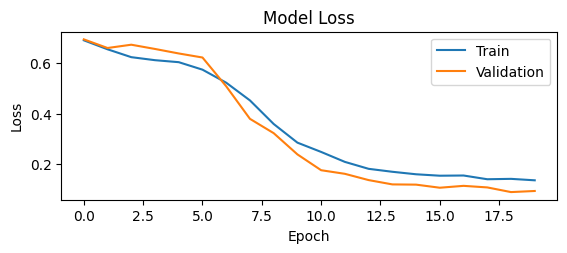

In [48]:
# plot training, validation, and test loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

In [49]:
from sklearn.metrics import classification_report

# Generate predictions for the validation set
y_pred = model.predict(X_val)

# Convert the predictions to binary values (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Generate a classification report
class_report = classification_report(Y_val, y_pred_binary)
print(class_report)


16/16 [==============================] - 1s 37ms/step
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       248
           1       0.98      0.96      0.97       248

    accuracy                           0.97       496
   macro avg       0.97      0.97      0.97       496
weighted avg       0.97      0.97      0.97       496



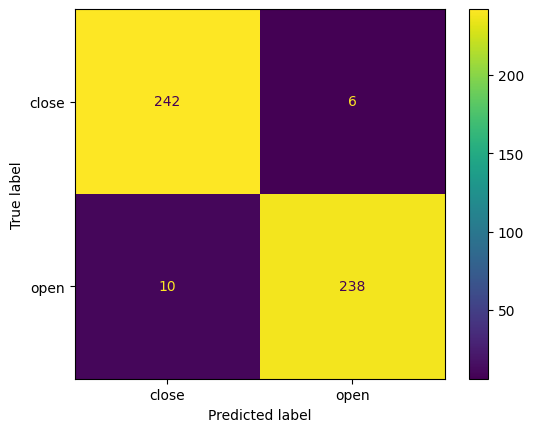

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Generate a confusion matrix
conf_matrix = confusion_matrix(Y_val, y_pred_binary)
model_classes = ["close","open"]
# Display the confusion matrix as a heatmap
display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model_classes)
display.plot()